<h1>Import all libraries</h1>

In [57]:
import re
import io

#General libraries needed
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#Libraries for data pre-processing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn import preprocessing

#For Decision Tree implementation
from scipy.stats import entropy
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

#For KNN implementation
from sklearn.neighbors import KNeighborsClassifier

#For Bagging implementation
from sklearn.ensemble import BaggingClassifier

#For AdaBoost implementation
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB

#For Random Forest implementation
from sklearn.ensemble import RandomForestClassifier


#Settings
%matplotlib inline
pd.options.display.float_format = '{:.2f}'.format
np.set_printoptions(threshold=np.nan)
sns.set()

<h1>Reading explored data into Dataframe</h1>

In [27]:
# Read from CSV file
df = pd.read_csv('census.csv')
#df = pd.read_pickle("explored_data")

In [28]:
# Check the columns using dtypes
print(df.dtypes)

age                int64
workclass         object
fnlwgt             int64
education         object
education-num      int64
marital_status    object
occupation        object
relationship      object
race              object
sex               object
capital_gain       int64
capital_loss       int64
hours_per_week     int64
native_country    object
Target_y          object
dtype: object


In [29]:
# Randomly sample 5 records with .sample(5)
df.sample(5)

,age,workclass,fnlwgt,education,education-num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,Target_y
18068,39,Federal-gov,30916,Some-college,10,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,1902,50,United-States,>50K
13630,44,Private,84535,Some-college,10,Divorced,Sales,Unmarried,White,Female,0,0,48,United-States,<=50K
27967,49,Private,287647,Masters,14,Divorced,Sales,Not-in-family,White,Male,4787,0,45,United-States,>50K
9163,41,Local-gov,185057,Masters,14,Never-married,Prof-specialty,Not-in-family,White,Female,0,0,40,United-States,<=50K
30790,21,Private,145119,Some-college,10,Never-married,Other-service,Own-child,Asian-Pac-Islander,Male,0,0,20,United-States,<=50K


In [30]:
#Decision Tree in SKLearn don't take in string well. So we use a label encoder to change that string to a numeric value
for column in df.columns:
    if df[column].dtype == type(object):
        #Create the label encoder
        le = preprocessing.LabelEncoder()
        #Convert the non numeric data to numeric
        df[column] = le.fit_transform(df[column])

In [31]:
# Randomly sample 5 records with .sample(5)
df.sample(5)

,age,workclass,fnlwgt,education,education-num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,Target_y
6954,47,2,121124,12,14,2,10,0,4,1,0,0,35,39,1
20075,43,2,223861,8,11,0,4,1,4,0,0,0,40,39,0
18340,53,4,158352,4,3,2,8,2,4,0,0,0,24,22,0
291,31,4,127595,11,9,0,10,1,4,0,0,0,40,39,0
12424,32,4,390997,3,2,4,5,1,3,1,0,0,50,26,0


Using `df.groupby()`, find out the number of records per `Target_y`. 

   Target_y      n
0         0  24720
1         1   7841


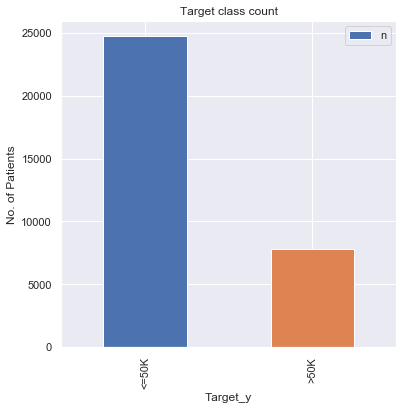

In [32]:
# Using groupby, find out the number of reviews with
# positive and negative sentiment respectively.
df_target = df.groupby('Target_y').size().reset_index(name='n')
print(df_target)

# How many patients in the dataset have been diagnosed positive and negative for diabetes?
fig = plt.figure(figsize=(6, 6))
ax1 = fig.add_subplot(111)
df_target.plot(kind='bar', x='Target_y', y='n', title = "Target class count", ax=ax1)
ax1.set_ylabel("No. of Patients")
plt.xticks(np.arange(0,2), ["<=50K", ">50K"])
plt.show()

### Train-Test Split
Now, assign the columns to $\textbf{X}$ and the `Target_y` score to $\textbf{y}$.

In [33]:
X = df[['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital_status', 'occupation', 'relationship', 'race',
       'sex','capital_gain','capital_loss','hours_per_week', 'native_country']]
y = df[['Target_y']]

Use `sklearn.model_selection.train_test_split` to split your dataset into two groups - the **training set** and the **test set**. For this example, we set the **test set** to be $50\%$ of the whole dataset.

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.50, random_state=0)

## k-Nearest Neighbor (KNN)

Refer to the following links on for detail explanation on the implementation:
- [kNN Classifier SKLearn Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)
- [DataCamp Implementation](https://www.datacamp.com/community/tutorials/k-nearest-neighbor-classification-scikit-learn)



In [35]:
#Create the kNN classifier and set the number of neighbors to be 3. Note that you can tune this number of neighbors
model = KNeighborsClassifier(n_neighbors=3)

#Fit the training feature Xs and training label Ys
model.fit(X_train,y_train)

C:\Users\andy_\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  """


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=3, p=2,
           weights='uniform')

In [36]:
#Use the trained model to predict the test data
y_pred = model.predict(X_test)

In [37]:
# Find the confusion matrix of the result
cm = confusion_matrix(y_pred, y_test)
print(cm)

# Find the accuracy and F1 score of the result
asr = accuracy_score(y_pred, y_test)
f1 = f1_score(y_pred, y_test)
print(asr)
print(f1)

[[10981  2557]
 [ 1342  1401]]
0.7605183956759413
0.41814654529174755


## Bagging (with Decision Tree)

Refer to the following links on for detail explanation on the implementation:
- [Bagging Classifier SKLearn Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html)

*Note that the default AdaBoost implementation in SKLearn is Decision Tree 

In [38]:
#Create the Bagging classifier. Default base classifiers is Decision Tree. 
# - n_estimator is the number of base classifiers (i.e. weak learners)
model = BaggingClassifier(n_estimators=50)

#Fit the training feature Xs and training label Ys
model.fit(X_train, y_train)

C:\Users\andy_\Anaconda3\lib\site-packages\sklearn\ensemble\bagging.py:621: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


BaggingClassifier(base_estimator=None, bootstrap=True,
         bootstrap_features=False, max_features=1.0, max_samples=1.0,
         n_estimators=50, n_jobs=None, oob_score=False, random_state=None,
         verbose=0, warm_start=False)

In [39]:
#Use the trained model to predict the test data
y_pred = model.predict(X_test)

In [40]:
# Find the confusion matrix of the result
cm = confusion_matrix(y_pred, y_test)
print(cm)

# Find the accuracy and F1 score of the result
asr = accuracy_score(y_pred, y_test)
f1 = f1_score(y_pred, y_test)
print(asr)
print(f1)

[[11435  1556]
 [  888  2402]]
0.8498863706160555
0.6628035320088301


## Bagging (with kNN)

In [41]:
#Create the kNN base classifier
knn = KNeighborsClassifier(n_neighbors=3)

#Create the Bagging classifier. Default base classifiers is Decision Tree. 
# - n_estimator is the number of base classifiers (i.e. weak learners)
model = BaggingClassifier(n_estimators=50, base_estimator=knn)

#Fit the training feature Xs and training label Ys
model.fit(X_train, y_train)

C:\Users\andy_\Anaconda3\lib\site-packages\sklearn\ensemble\bagging.py:621: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


BaggingClassifier(base_estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=3, p=2,
           weights='uniform'),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=1.0, n_estimators=50, n_jobs=None, oob_score=False,
         random_state=None, verbose=0, warm_start=False)

In [42]:
#Use the trained model to predict the test data
y_pred = model.predict(X_test)

In [43]:
# Find the confusion matrix of the result
cm = confusion_matrix(y_pred, y_test)
print(cm)

# Find the accuracy and F1 score of the result
asr = accuracy_score(y_pred, y_test)
f1 = f1_score(y_pred, y_test)
print(asr)
print(f1)

[[11170  2631]
 [ 1153  1327]]
0.7675818438670843
0.41223982603292947


## AdaBoost (with Decision Tree)

Refer to the following links on for detail explanation on the implementation:
- [AdaBoost Classifier SKLearn Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html)
- [DataCamp Implementation](https://www.datacamp.com/community/tutorials/adaboost-classifier-python)
- [Setting Learning Rate and N Estimators](https://stats.stackexchange.com/questions/82323/shrinkage-parameter-in-adaboost)

*Note that the default AdaBoost implementation in SKLearn is Decision Tree 


In [44]:
#Create the AdaBoost classifier. Default base classifiers is Decision Tree. 
# - n_estimator is the number of base classifiers (i.e. weak learners)
# - learning_rate controls the weight adjustments of each base classifiers. Default is 1
model = AdaBoostClassifier(n_estimators=50,learning_rate=1)

#Fit the training feature Xs and training label Ys
model.fit(X_train, y_train)

C:\Users\andy_\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1,
          n_estimators=50, random_state=None)

In [45]:
#Use the trained model to predict the test data
y_pred = model.predict(X_test)

In [46]:
# Find the confusion matrix of the result
cm = confusion_matrix(y_pred, y_test)
print(cm)

# Find the accuracy and F1 score of the result
asr = accuracy_score(y_pred, y_test)
f1 = f1_score(y_pred, y_test)
print(asr)
print(f1)

[[11576  1535]
 [  747  2423]]
0.8598366193722744
0.6798540965207631


## AdaBoost (with Gaussian Navie Bayes)
Refer to the following links on for detail explanation on the implementation:
- [Gaussian Naive Bayes Classifier SKLearn Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html)
- [Naive Bayes Classifier video](https://www.youtube.com/watch?v=CPqOCI0ahss)

In [47]:
model = GaussianNB()
#Fit the training feature Xs and training label Ys
model.fit(X_train, y_train)

C:\Users\andy_\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GaussianNB(priors=None, var_smoothing=1e-09)

In [48]:
#Use the trained model to predict the test data
y_pred = model.predict(X_test)
# Find the confusion matrix of the result
cm = confusion_matrix(y_pred, y_test)
print(cm)

# Find the accuracy and F1 score of the result
asr = accuracy_score(y_pred, y_test)
f1 = f1_score(y_pred, y_test)
print(asr)
print(f1)

[[11721  2703]
 [  602  1255]]
0.7970026411154106
0.4316423043852106


In [49]:
nb = GaussianNB()

model = AdaBoostClassifier(n_estimators=50,learning_rate=1, base_estimator=nb)
#model = BaggingClassifier(n_estimators=50, base_estimator=knn)


#Fit the training feature Xs and training label Ys
model.fit(X_train, y_train)

C:\Users\andy_\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=GaussianNB(priors=None, var_smoothing=1e-09),
          learning_rate=1, n_estimators=50, random_state=None)

In [50]:
#Use the trained model to predict the test data
y_pred = model.predict(X_test)
# Find the confusion matrix of the result
cm = confusion_matrix(y_pred, y_test)
print(cm)

# Find the accuracy and F1 score of the result
asr = accuracy_score(y_pred, y_test)
f1 = f1_score(y_pred, y_test)
print(asr)
print(f1)

[[12248  3922]
 [   75    36]]
0.754499109391315
0.017694765298599164


## Ultimate Homework
As I mentioned in lecture, it is possible to ensemble different models. So how can we do that in python? Check out the following link and try it for your project!:
https://machinelearningmastery.com/ensemble-machine-learning-algorithms-python-scikit-learn/ 

## Random Forest

In [58]:
#Instantiate model with 1000 decision trees
rf = RandomForestClassifier(n_estimators = 1000, random_state = 0)

#Fit the training feature Xs and training label Ys
rf.fit(X_train, y_train);

C:\Users\andy_\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


In [59]:
#Use the trained model to predict the test data
y_pred = rf.predict(X_test)

# Find the confusion matrix of the result
cm = confusion_matrix(y_pred, y_test)
print(cm)

# Find the accuracy and F1 score of the result
asr = accuracy_score(y_pred, y_test)
f1 = f1_score(y_pred, y_test)
print(asr)
print(f1)

[[11521  1498]
 [  802  2460]]
0.858731036177139
0.6814404432132964
